In [ ]:
pip install lightgbm

In [ ]:
pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier

from IPython.display import display # Allows the use of display() for DataFrames

import warnings
warnings.filterwarnings('ignore')

In [31]:
data = pd.read_excel('veu_data.xlsx')
data=data.dropna()

main = 'active_power'
n = 50
df = data
from math import ceil
df = df.dropna()
np.corrcoef(df['wind_speed'], df['active_power'])
df = df[(df['wind_speed']>3) & (df['wind_speed']<25)]
max_wind = df['wind_speed'].max()
step = 0.1
num = ceil(max_wind/0.1)
divided = []
sorted_by_speed = df[['timestamp','wind_speed','active_power']].sort_values('wind_speed')
for i in range(1,num):
    divided.append(sorted_by_speed.iloc[((sorted_by_speed['wind_speed']>=i*step)&((sorted_by_speed['wind_speed']<(i+1)*step))).values])
divided = [i for i in divided if not(i.empty) == True]
new_data = pd.DataFrame(columns = ['wind_speed','active_power'])
for i in range(0,len(divided)):
    df1 = divided[i]
    Q1 = df1[['active_power']].quantile(0.05)
    Q3 = df1[['active_power']].quantile(0.75)
    IQR = Q3 - Q1
    divided[i] = df1[~((df1[['active_power']] < (Q1 - IQR)) |(df1[['active_power']] > (Q3 + IQR))).any(axis=1)]

data = pd.concat(divided)
data=data.drop(['timestamp'], axis=1)
X = data.drop('active_power', axis=1)
y = data['active_power']

In [187]:
data = pd.read_csv('data.csv')
data=data.drop(['dateTime', 'Amprion','50Hertz', 'TransnetBW'], axis=1)
X = data.drop('TenneTTSO', axis=1)
y = data['TenneTTSO']
main = 'TenneTTSO'
n = 50

In [202]:
data = pd.read_csv('dataforpredict.csv')
data=data.drop(['dateTime'], axis=1)
X = data.drop('energy', axis=1)
y = data['energy']
main = 'energy'
n = 50

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dev_X, val_X, dev_y, val_y = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
y_test.index=list(range(len(y_test.index)))

In [33]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.004,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], 
                      )
    
    pred_test_y = np.array(model.predict(test_X, num_iteration=model.best_iteration))
    return pred_test_y, model, evals_result
def run_xgb(train_X, train_y, val_X, val_y, test_X):
    params = {'objective': 'reg:linear', 
          'eval_metric': 'rmse',
          'eta': 0.001,
          'max_depth': 10, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42, 
          'silent': True}
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 100, verbose_eval=100)
    
    dtest = xgb.DMatrix(test_X)
    xgb_pred_y = np.array(model_xgb.predict(dtest))
    
    return xgb_pred_y, model_xgb
def run_cat(dev_X, dev_y, val_X, val_y, X_test):
    cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)
    cb_model.fit(dev_X, dev_y,
             eval_set=(val_X, val_y),
             use_best_model=True,
             verbose=50)
    pred_test_cat = np.array(cb_model.predict(X_test))
    return pred_test_cat, cb_model

In [34]:
def total_predict(pred_test,pred_test_xgb,pred_test_cat):
    sub = pd.DataFrame()
    sub_lgb = pd.DataFrame()
    sub_lgb["energy"] = pred_test

    sub_xgb = pd.DataFrame()
    sub_xgb["energy"] = pred_test_xgb

    sub_cat = pd.DataFrame()
    sub_cat["energy"] = pred_test_cat

    sub["energy"] = (sub_lgb["energy"] * 0.5 + sub_xgb["energy"] * 0.3 + sub_cat["energy"] * 0.2)
    return sub["energy"]

In [35]:
def plotting(y_test, pred_test,x1,x2):
    fig, axs = plt.subplots()
    #Plot for LightGBM predictions
    axs.plot( y_test, label = "test_data", color = "b")
    axs.plot(pred_test, label = "prediction ", color = "g")
    plt.xlim(x1,x2)
    plt.ylabel('kWt')

    axs.legend()

In [87]:
def metrics(y_test,X_test):
    df = pd.DataFrame(columns=['model','MSE','R^2', 'MAPE'])
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_absolute_percentage_error
    df['model'] = ['Light','XGB','CAT','Total']
    df['MSE']=[mean_squared_error(y_test, model.predict(X_test)),mean_squared_error(y_test, pred_test_xgb),mean_squared_error(y_test, pred_test_cat),mean_squared_error(y_test, total)]
    df['R^2'] =[r2_score(y_test, model.predict(X_test)),r2_score(y_test, pred_test_xgb),r2_score(y_test, pred_test_cat) ,r2_score(y_test, total)]
    df['MAPE']= [mean_absolute_percentage_error(y_test, model.predict(X_test)),mean_absolute_percentage_error(y_test, pred_test_xgb),mean_absolute_percentage_error(y_test, pred_test_cat),mean_absolute_percentage_error(y_test, total) ]
    return df

In [37]:
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, X_test)
print("LightGBM Training Completed...")

LightGBM Training Completed...


In [38]:
pred_test_xgb, model_xgb = run_xgb(dev_X, dev_y, val_X, val_y, X_test)
print("XGB Training Completed...")

[0]	train-rmse:1.24164	valid-rmse:1.24427
[100]	train-rmse:1.12531	valid-rmse:1.12772
[200]	train-rmse:1.02016	valid-rmse:1.02237
[300]	train-rmse:0.92512	valid-rmse:0.92716
[400]	train-rmse:0.83930	valid-rmse:0.84120
[500]	train-rmse:0.76179	valid-rmse:0.76357
[600]	train-rmse:0.69185	valid-rmse:0.69353
[700]	train-rmse:0.62876	valid-rmse:0.63035
[800]	train-rmse:0.57193	valid-rmse:0.57344
[900]	train-rmse:0.52073	valid-rmse:0.52217
[1000]	train-rmse:0.47471	valid-rmse:0.47610
[1100]	train-rmse:0.43336	valid-rmse:0.43471
[1200]	train-rmse:0.39625	valid-rmse:0.39757
[1300]	train-rmse:0.36304	valid-rmse:0.36434
[1400]	train-rmse:0.33337	valid-rmse:0.33465
[1500]	train-rmse:0.30692	valid-rmse:0.30819
[1600]	train-rmse:0.28342	valid-rmse:0.28470
[1700]	train-rmse:0.26259	valid-rmse:0.26389
[1800]	train-rmse:0.24419	valid-rmse:0.24551
[1900]	train-rmse:0.22804	valid-rmse:0.22939
[1999]	train-rmse:0.21402	valid-rmse:0.21540
XGB Training Completed...


In [39]:
pred_test_cat, model_cat = run_cat(dev_X, dev_y, val_X, val_y, X_test)
print("CAT Training Completed...")

0:	learn: 1.1827229	test: 1.1850371	best: 1.1850371 (0)	total: 192ms	remaining: 1m 35s
50:	learn: 0.1644137	test: 0.1644486	best: 0.1644486 (50)	total: 1.31s	remaining: 11.5s
100:	learn: 0.1334431	test: 0.1340278	best: 0.1340278 (100)	total: 2.44s	remaining: 9.64s
150:	learn: 0.1325937	test: 0.1334619	best: 0.1334565 (149)	total: 3.61s	remaining: 8.34s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1334520965
bestIteration = 151

Shrink model to first 152 iterations.
CAT Training Completed...


In [40]:
total = total_predict(pred_test,pred_test_xgb,pred_test_cat)

In [66]:
sub = pd.DataFrame()
sub_lgb = pd.DataFrame()
sub_lgb["energy"] = pred_test

sub_xgb = pd.DataFrame()
sub_xgb["energy"] = pred_test_xgb

sub_cat = pd.DataFrame()
sub_cat["energy"] = pred_test_cat

sub['pedict']=(sub_lgb["energy"] * 0.5 + sub_xgb["energy"] * 0.3 + sub_cat["energy"] * 0.2)
sub['wind']=X_test
sub = sub.sort_values('wind')
sub = sub.dropna()
sub, data

(        pedict      wind
 5     0.169997   3.00736
 3013  1.766357   3.03339
 3707  0.971575   3.04945
 200   0.880300   3.06297
 3260  3.227116   3.07342
 ...        ...       ...
 3499  1.829113  15.11300
 3519  2.145693  15.34320
 3523  1.519168  15.41480
 3526  0.752220  15.66150
 3509  1.379061  16.90440
 
 [630 rows x 2 columns],
        wind_speed  active_power  predict
 13687    3.000542      0.081824      NaN
 5186     3.000700      0.084437      NaN
 9725     3.001560      0.088188      NaN
 19825    3.002304      0.064706      NaN
 9746     3.002580      0.070288      NaN
 ...           ...           ...      ...
 7037    20.801600      3.841560      NaN
 18462   20.824612      3.428704      NaN
 22662   20.827436      3.515272      NaN
 18467   20.930674      3.404270      NaN
 18463   21.234711      3.580091      NaN
 
 [18918 rows x 3 columns])

In [79]:
sub = pd.DataFrame()
sub['wind'] = X_test
sub['predict'] = pred_test

Text(0, 0.5, 'Энергия ВЭС, кВт')

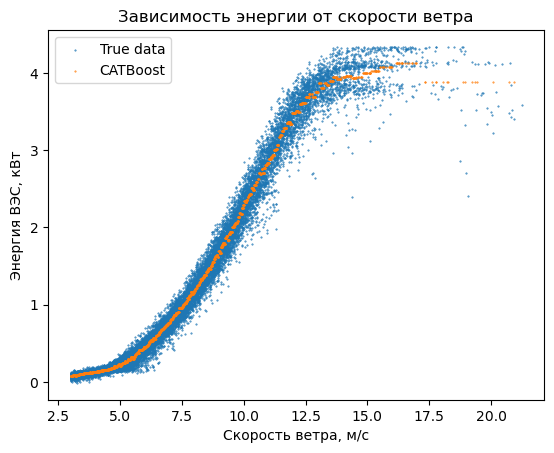

In [80]:
plt.scatter(data['wind_speed'], data['active_power'], s=0.2, label = 'True data' )
plt.scatter(sub['wind'], sub['predict'], s=0.2, label = 'CATBoost' )
plt.legend()
plt.title('Зависимость энергии от скорости ветра')
plt.xlabel('Скорость ветра, м/c')
plt.ylabel('Энергия ВЭС, кВт')

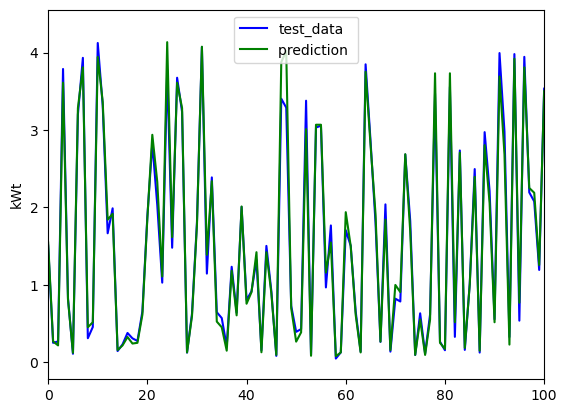

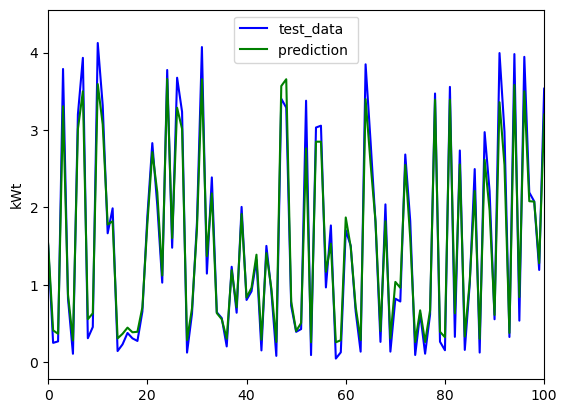

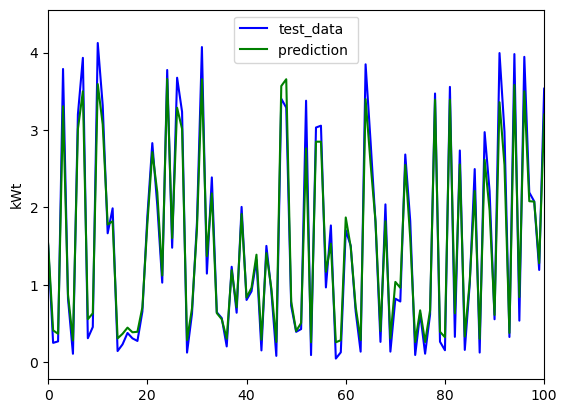

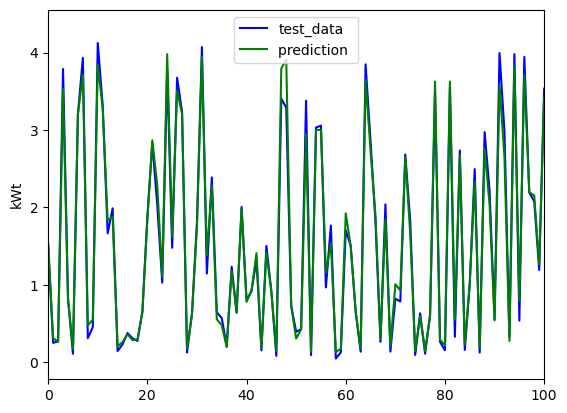

In [41]:
plotting(y_test, pred_test,0,100)
plotting(y_test, pred_test_xgb,0,100)
plotting(y_test, pred_test_xgb,0,100)
plotting(y_test, total,0,100)

In [232]:
import pickle
for i in ['model_xgb','model', 'model_cat']:
    with open(f'model {i}.pkl','wb') as f:
        exec(f"clf = {i}")
        pickle.dump(clf,f)

In [88]:
metric = metrics(y_test,X_test)

In [89]:
metric

,model,MSE,R^2,MAPE
0,Light,0.017356,0.988624,0.145512
1,XGB,0.045647,0.970081,0.543019
2,CAT,0.017210,0.988720,0.145998
3,Total,0.019823,0.987007,0.234951


In [172]:
data= data.iloc[:2000]
data

,wind_speed,active_power
0,4.07814,0.165642
1,4.72546,0.138439
2,5.69182,0.165273
3,6.04625,0.197691
4,5.17281,0.152508
...,...,...
1996,8.73853,1.503784
1997,9.22551,1.695018
1998,8.47736,1.307898
1999,9.48830,1.975379


In [173]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers.legacy import SGD
import math

from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [174]:
def convert(data, main, n):
    training_data_len = math.ceil(len(data) * .8)
    train_data = data[:training_data_len].iloc[:,:] 
    test_data = data[training_data_len:].iloc[:,:]
    dataset_train = train_data[main].values 
    # Reshaping 1D to 2D array
    dataset_train = np.reshape(dataset_train, (-1,1)) 
    dataset_train.shape
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1))
    # scaling dataset
    scaled_train = scaler.fit_transform(dataset_train)
    # Selecting Open Price values
    dataset_test = test_data[main].values 
    # Reshaping 1D to 2D array
    dataset_test = np.reshape(dataset_test, (-1,1))  
    # Normalizing values between 0 and 1
    scaled_test = scaler.fit_transform(dataset_test)
    X_train = []
    y_train = []
    for i in range(n, len(scaled_train)):
        X_train.append(scaled_train[i-n:i, 0])
        y_train.append(scaled_train[i, 0])
    X_test = []
    y_test = []
    for i in range(n, len(scaled_test)):
        X_test.append(scaled_test[i-n:i, 0])
        y_test.append(scaled_test[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
 
    #Reshaping
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    y_train = np.reshape(y_train, (y_train.shape[0],1))
    X_test, y_test = np.array(X_test), np.array(y_test)

    #Reshaping
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    y_test = np.reshape(y_test, (y_test.shape[0],1))    
    return X_train, y_train, X_test, y_test,train_data, test_data, scaler

In [175]:
def all_model(X_train,y_train,n):    
    regressor = Sequential()

    # adding RNN layers and dropout regularization
    regressor.add(SimpleRNN(units = n, 
                            activation = "tanh",
                            return_sequences = True,
                            input_shape = (X_train.shape[1],1)))
    regressor.add(Dropout(0.2))

    regressor.add(SimpleRNN(units = n, 
                            activation = "tanh",
                            return_sequences = True))

    regressor.add(SimpleRNN(units = n,
                            activation = "tanh",
                            return_sequences = True))

    regressor.add( SimpleRNN(units = n))

    # adding the output layer
    regressor.add(Dense(units = 1,activation='sigmoid'))

    # compiling RNN
    regressor.compile(optimizer = SGD(learning_rate=0.01,
                                      decay=1e-6, 
                                      momentum=0.9, 
                                      nesterov=True), 
                      loss = "mean_squared_error")

    # fitting the model
    regressor.fit(X_train, y_train, epochs = 20, batch_size = 200)
    regressor.summary()
    regressorLSTM = Sequential()
 
    #Adding LSTM layers
    regressorLSTM.add(LSTM(n, 
                           return_sequences = True, 
                           input_shape = (X_train.shape[1],1)))
    regressorLSTM.add(LSTM(n, 
                           return_sequences = False))
    regressorLSTM.add(Dense(n//2))

    #Adding the output layer
    regressorLSTM.add(Dense(1))

    #Compiling the model
    regressorLSTM.compile(optimizer = 'adam',
                          loss = 'mean_squared_error',
                          metrics = ["accuracy"])

    #Fitting the model
    regressorLSTM.fit(X_train, 
                      y_train, 
                      batch_size = 200, 
                      epochs = 20)
    regressorLSTM.summary()
    regressorGRU = Sequential()
 
    # GRU layers with Dropout regularisation
    regressorGRU.add(GRU(units=n, 
                         return_sequences=True,
                         input_shape=(X_train.shape[1],1),
                         activation='tanh'))
    regressorGRU.add(Dropout(0.2))

    regressorGRU.add(GRU(units=n, 
                         return_sequences=True,
                         activation='tanh'))

    regressorGRU.add(GRU(units=n, 
                         return_sequences=True,
                         activation='tanh'))

    regressorGRU.add(GRU(units=n, 
                         activation='tanh'))

    # The output layer
    regressorGRU.add(Dense(units=1,
                           activation='relu'))
    # Compiling the RNN
    regressorGRU.compile(optimizer=SGD(learning_rate=0.01, 
                                       decay=1e-7, 
                                       momentum=0.9, 
                                       nesterov=False),
                         loss='mean_squared_error')

    # Fitting the data
    regressorGRU.fit(X_train,y_train,epochs=20,batch_size=200)
    regressorGRU.summary()
    
    return regressor, regressorLSTM, regressorGRU

In [176]:
def predict_row(X_test):
    y_RNN = regressor.predict(X_test)
    y_LSTM = regressorLSTM.predict(X_test)
    y_GRU = regressorGRU.predict(X_test)
    # scaling back from 0-1 to original
    y_RNN_O = scaler.inverse_transform(y_RNN) 
    y_LSTM_O = scaler.inverse_transform(y_LSTM) 
    y_GRU_O = scaler.inverse_transform(y_GRU)  
    return y_RNN_O ,y_LSTM_O ,y_GRU_O

In [177]:
def plotting_row(test_data, main, n):
    fig, axs = plt.subplots(3,figsize =(18,12),sharex=True, sharey=True)
    fig.suptitle('Model Predictions')

    #Plot for RNN predictions
    axs[0].plot(test_data.index, test_data[main], label = "test_data", color = "g")
    axs[0].plot(test_data.index[-len(y_RNN_O):], y_RNN_O, label = "y_RNN", color = "red", alpha=0.75)
    axs[0].title.set_text("RNN")

    #Plot for LSTM predictions
    axs[1].plot(test_data.index, test_data[main], label = "test_data", color = "g")
    axs[1].plot(test_data.index[-len(y_RNN_O):], y_LSTM_O, label = "y_LSTM", color = "red", alpha=0.75)
    axs[1].legend()
    axs[1].title.set_text("LSTM")

    #Plot for GRU predictions
    axs[2].plot(test_data.index, test_data[main], label = "test_data", color = "g")
    axs[2].plot(test_data.index[-len(y_RNN_O):], y_GRU_O, label = "y_GRU", color = "red", alpha=0.75)
    axs[2].legend()
    axs[2].title.set_text("GRU")

    plt.xlabel("Days")
    plt.ylabel("Wt")

    plt.show()   

In [178]:
X_train, y_train, X_test, y_test, test_data, train_data, scaler = convert(data, main, n)

In [179]:
regressor, regressorLSTM, regressorGRU = all_model(X_train,y_train,n)   

Epoch 1/20
8/8 [==============================] - 5s 172ms/step - loss: 0.0992
Epoch 2/20
8/8 [==============================] - 2s 197ms/step - loss: 0.0384
Epoch 3/20
8/8 [==============================] - 1s 178ms/step - loss: 0.0365
Epoch 4/20
8/8 [==============================] - 1s 171ms/step - loss: 0.0347
Epoch 5/20
8/8 [==============================] - 1s 168ms/step - loss: 0.0336
Epoch 6/20
8/8 [==============================] - 1s 183ms/step - loss: 0.0327
Epoch 7/20
8/8 [==============================] - 1s 183ms/step - loss: 0.0310
Epoch 8/20
8/8 [==============================] - 1s 158ms/step - loss: 0.0301
Epoch 9/20
8/8 [==============================] - 1s 165ms/step - loss: 0.0284
Epoch 10/20
8/8 [==============================] - 1s 168ms/step - loss: 0.0284
Epoch 11/20
8/8 [==============================] - 1s 173ms/step - loss: 0.0278
Epoch 12/20
8/8 [==============================] - 1s 172ms/step - loss: 0.0269
Epoch 13/20
8/8 [==============================] 

In [44]:
import pickle
for i in ['regressor', 'regressorLSTM', 'regressorGRU']:
    with open(f'model {i}.pkl','wb') as f:
        exec(f"clf = {i}")
        pickle.dump(clf,f)

In [180]:
def metrics_row(main,n):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score
    model = ['RNN', 'LSTM','GRU']
    mse = []
    r =[]
    mse.append((mean_squared_error(y_test,y_RNN_O)))
    r.append(r2_score(y_test,y_RNN_O))
    mse.append(mean_squared_error(y_test,y_LSTM_O))
    r.append(r2_score(y_test,y_LSTM_O))
    mse.append(mean_squared_error(y_test,y_GRU_O))
    r.append(r2_score(y_test,y_GRU_O))
    df = pd.DataFrame(columns=['model','MSE','R^2'])
    df['model'] = ['RNN', 'LSTM','GRU']
    df['MSE']=mse
    df['R^2'] =r
    return df

In [1]:
y_RNN_O ,y_LSTM_O ,y_GRU_O = predict_row(X_test[0][np.newaxis])

NameError: name 'predict_row' is not defined

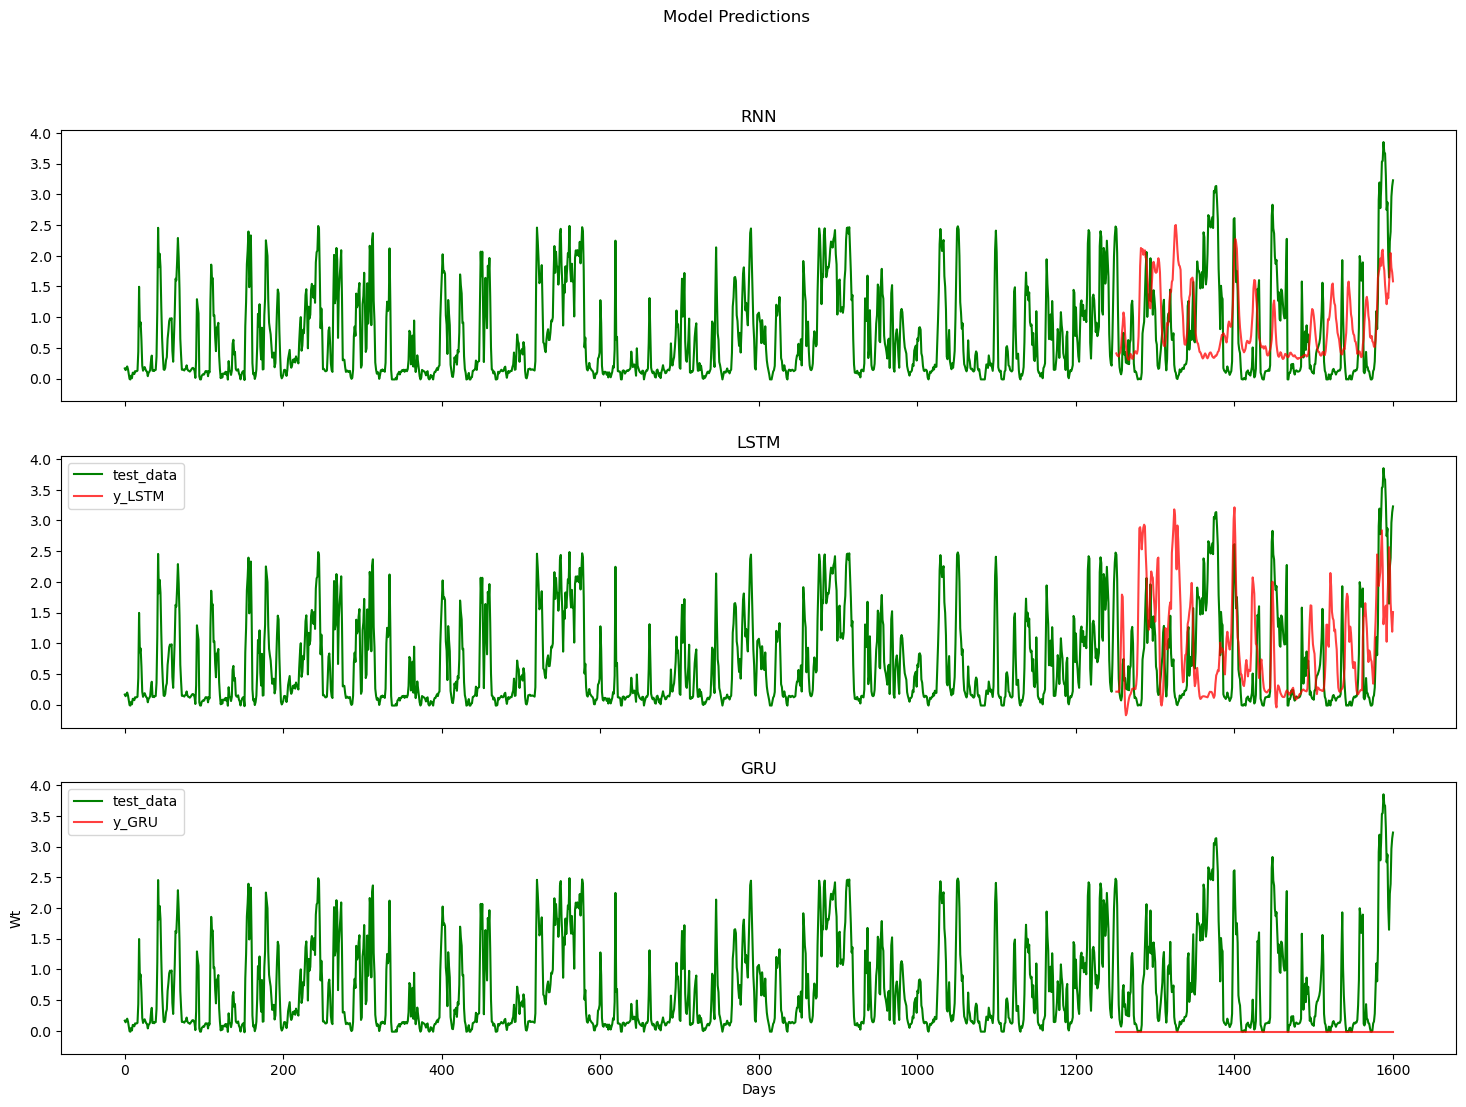

In [182]:
plotting_row(test_data, main, n)

In [183]:
dfm = metrics_row(main,n)
dfm

,model,MSE,R^2
0,RNN,0.537648,-6.778603
1,LSTM,0.769670,-10.135465
2,GRU,0.158562,-1.294050
